# OneModel: an open-source SBML modeling tool focused on accessibility, simplicity and modularity

----

## Install OneModel and dependencies needed for the workshop

In [ ]:
# Install onemodel.
!pip install -I --no-cache-dir https://github.com/fernandonobel/onemodel/archive/jupyter.zip
    
# Install roadrunner for SBML simulations.
!pip install libroadrunner

# Download examples.
!wget https://raw.githubusercontent.com/fernandonobel/onemodel/develop/examples/ex01_simple_gene_expression.one
!wget https://raw.githubusercontent.com/fernandonobel/onemodel/develop/examples/ex03_protein_constitutive.one
!wget https://raw.githubusercontent.com/fernandonobel/onemodel/develop/examples/ex05_protein_induced.one

In [1]:
import onemodel
import roadrunner

# Custom plot for roadrunner.
# Plots each state in a different plot.
def plot(rr):

    import pylab as p

    result = rr.getSimulationData()

    if result is None:
        raise Exception("no simulation result")

    # assume result is a standard numpy array

    selections = rr.timeCourseSelections

    if len(result.shape) != 2 or result.shape[1] != len(selections):
        raise Exception("simulation result columns not equal to number of selections,"
                        "likely a simulation has not been run")

    times = result[:,0]

    for i in range(1, len(selections)):
        series = result[:,i]
        name = selections[i]
            
        fig, ax = p.subplots()
        ax.plot(times, series, label=str(name))
        ax.legend()
        
# Add the custom plot to roadrunner.
roadrunner.RoadRunner.plot = plot

----

## WORKPLACE 01: The OneModel REPL (Read-Eval-Print Loop)

OneModel has an interactive command-line REPL (read-eval-print loop).

**Note:** use only single-line commands. To use a multiline command (i.e. a parameter block) you have to introduce manually intro lines using `;`

For example,

```
# Multi-line version of a parameter block.
parameter
  foo = 10
  bar = 20
end

# Singe-line parameter block.
parameter; foo = 10; bar = 20; end

# Even easier just use regular single-line commands.
parameter foo = 10
parameter bar = 20
```

In [ ]:
# Execute the OneModel REPL (Read-Evaluate-Print Loop).
model = onemodel.shell()

# Export the model into SBML.
sbml = model.get_SBML_string()

# Print the defined model.
print("\n=== Built-in and user-defined variables =============")
print(model)

# Print the model exported into SBML.
print("\n=== SBML representation of the model ================")
print(sbml)

----

## WORKPLACE 02: Define models using text

Instead of using the OneModel REPL, we can define models permanently using scripts.

In [ ]:
import onemodel

# Define the model using a multi-line string.
text = """
species A = 0 
species B = 0 

parameter k = 1 

reaction A -> B ; k*A 
"""

# Evalute the model.
model = onemodel.evaluate(text)

# Print the result.
print(model)

----

## WORKPLACE 03: How to edit files using Google Colab

Google Colab only allows to edit files with .txt or .py extensions. OneModel uses .one as extensions, so to bypass this limitation we can use "%%file" to directly write text into a file.

We will use this special command to write files with OneModel syntax. 

When editint the contents of the following cell, use ctrl+intro to write into the file.

In [ ]:
%%file src/test_model.one

# Everything you write here will be saved into "test_model.one" when you press ctrl+intro or execute this cell.

species A = 0
species B = 0

parameter k = 1

reaction A -> B ; k*A

We can read the contents of a file in two ways:

1. You can download the file from the left pane and open it localy with a text editor.
2. Or, you can just execute the following command to print the contents of the file.

In [ ]:
# Print the contents of "test_model.one" when you press ctrl-intro or execute this cell.
%cat src/test_model.one

Now, we can use OneModel to directly read from the file `test_model.one` where we have defined our model. This is the best way to use OneModel

----

## WORKPLACE 04: Define models using files

In [12]:
%%file src/my_model.one

species A = 0
species B = 0
species C = 0

parameter k_A = 1
parameter d_A = 0.1
parameter k_B = 1
parameter k_C = 1

reaction 0 -> A ; k_A
reaction A -> 0 ; d_A*A
reaction A -> B ; k_B*A
reaction B + B -> C ; k_C*B*B

Overwriting src/my_model.one


In [ ]:
# Set the path where our model is located.
filepath = "src/my_model.one"

# Load the model.
model = onemodel.load(filepath)
print(model)

# Export the model into SBML.
sbml = model.get_SBML_string()

# Simulate the SBML and plot the results.
rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

----

## WORKPLACE 05: `ProteinConstitutive`
$$\require{mhchem}$$ 
**Set of reactions:**

* mRNA transcription: $\ce{\emptyset->[k_m] mRNA}$
* mRNA degradation: $\ce{mRNA ->[d_m] \emptyset}$
* Protein translation: $\ce{mRNA ->[k_p] mRNA + protein}$
* Protein degradation: $\ce{protein ->[d_p] \emptyset}$

**Set of parameters:**

* Transcription rate: $k_m$
* mRNA degradation rate: $d_m$
* Translation rate: $k_p$
* Protein degradation rate: $d_p$

**Set of species:**

* Concentration of mRNA: $mRNA$
* Concentration of protein: $protein$

In [ ]:
%%file src/protein_constitutive.one

# TODO: Write your model here.

### Definition of ProteinConstitutive. ###

## ProteinConstitutive models constitutive gene expression. ##
model ProteinConstitutive  # Start declaring model.

  species mRNA=0, protein=0  # mRNA and protein concentration.
  
  parameter
    k_m=1, d_m=1  # mRNA transcription and degradation rate.
    k_p=1, d_p=1  # Protein translation and degradation rate.
  end
  
  reaction
    0 -> mRNA              ; k_m          # mRNA transcription.
    mRNA -> 0              ; d_m*mRNA     # mRNA degradation.
    mRNA -> mRNA + protein ; k_p*mRNA     # Protein translation.
    protein -> 0           ; d_p*protein  # Protein degradation.
  end
end  # End declaring model.

## Example of how to use ProteinConstitutive. ##
standalone        
  A = ProteinConstitutive()
end

In [ ]:
filepath = "src/protein_constitutive.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

----

## WORKPLACE 06: `ProteinInduced`

In [ ]:
%%file src/protein_induced.one

# TODO: Write your model here.

### Definition of ProteinInduced. ###

from protein_constitutive import ProteinConstitutive

## ProteinInduced extends the ProteinConstitutive model to make ##
## the expression inducible by a transcription factor.          ##
model ProteinInduced

  extends ProteinConstitutive

  species TF     # Define the transcription factor as an input.
  species k_m=0  # Override the parameter k_m to be a species.
  
  parameter
    h = 1        # Half-activation threshold.
    k_m_max = 1  # Maximum transcription rate.
  end
  
  # Set the value of k_m as an substitution equation.
  rule k_m := k_m_max * TF/(TF+h)
end

## Example of how to use ProteinInduced. ##
standalone
  A = ProteinConstitutive()
  B = ProteinInduced()

  rule B.TF := A.protein  # Set protein A as the transcription factor of B.
end


In [ ]:
filepath = "src/protein_induced.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

----

## WORKPLACE 07: Antithetic Controller
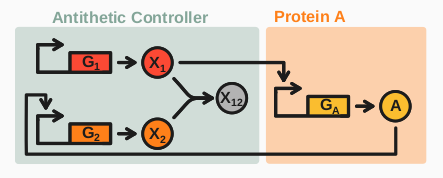

In [ ]:
%%file src/antithetic_controller.one

# TODO: Write your model here.



In [ ]:
filepath = "src/antithetic_controller.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

## WORKPLACE 08: Install dependencies

In [1]:
%%file onemodel.toml

[dependencies]

protein_expression = "https://github.com/fernandonobel/protein_expression"

Overwriting onemodel.toml


In [4]:
onemodel.install_dependencies()

Load "onemodel.toml".
Installed https://github.com/fernandonobel/protein_expression as "protein_expression"
All dependencies installed.


In [5]:
onemodel.shell()

OneModel v1.0.0
Documentation: https://onemodel.readthedocs.io/

one> import protein_expression
IndexError: list index out of range
one> import protein_expression.protein_constitutive
one> import protein_expression.protein_induced
one> locals(protein_expression)
Name             Value     Documentation
---------------  --------  ---------------
protein_induced  <module>
__file__         ''
__name__         ''
__doc__          ''

one> locals(protein_expression.protein_induced)
Name                 Value                                                                                                         Documentation
-------------------  ------------------------------------------------------------------------------------------------------------  ---------------
ProteinInduced       <model>
ProteinConstitutive  <model>
__file__             '/home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/lib/protein_expression/src/protein_induced.one'
__name__             'protein_induced'

## WORKPLACE 09 Build models using pre-exisisting models

In [14]:
%%file src/antithetic_controller_2.one

import protein_expression.protein_induced

locals(protein_induced)

#from protein_expression.protein_constitutive import ProteinConstitutive
#from protein_expression.protein_induced import ProteinInduced

#A = ProteinConstitutive()
#B = ProteinInduced()

#rule B.TF := A.protein

Overwriting src/antithetic_controller_2.one


In [15]:
import onemodel

filepath = "src/antithetic_controller_2.one"

model = onemodel.load(filepath)

print(model)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 10, 100) # (t_start, t_end, number_of_points)
rr.plot()

Name                 Value                                                                                                         Documentation
-------------------  ------------------------------------------------------------------------------------------------------------  ---------------
ProteinInduced       <model>
ProteinConstitutive  <model>
__file__             '/home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/lib/protein_expression/src/protein_induced.one'
__name__             'protein_induced'
__doc__              ''

Name                Value     Documentation
------------------  --------  ---------------
protein_induced     <module>
protein_expression  <module>


NameError: name 'roadrunner' is not defined

## WORKPLACE 10: The host-aware model for *E. coli*

In [2]:
%%file onemodel.toml

[dependencies]

protein_expression = "https://github.com/fernandonobel/protein_expression"
host_aware_model = "https://github.com/fernandonobel/host_aware_model"

Overwriting onemodel.toml


In [3]:
onemodel.install_dependencies()

Load "onemodel.toml".
Installed https://github.com/fernandonobel/protein_expression as "protein_expression"
Installed https://github.com/fernandonobel/host_aware_model as "host_aware_model"
All dependencies installed.


In [10]:
%%file src/host_aware_example.one

from host_aware_model.host_aware_model.protein_constitutive import ProteinConstitutive
from host_aware_model.host_aware_model.protein_ribosomal import ProteinRibosomal
from host_aware_model.host_aware_model.protein_non_ribosomal import ProteinNonRibosomal
from host_aware_model.host_aware_model.host_aware_model import HostAwareModel
from host_aware_model.mass_equation.mass_equation import MassEquation
from host_aware_model.mass_equation.mass_interpolated import MassInterpolated


cell = HostAwareModel()
mass = MassInterpolated()

parameter __t_end = 2000

# Define a constitutive expressed exogenous protein.
p_exo = ProteinConstitutive()

# Add protein A to the model.
rule
    p_exo.nu_t := cell.nu_t
    p_exo.mu := cell.mu
    p_exo.r := cell.r
    p_exo.m_h := cell.m_h
    p_exo.J_host_sum := cell.J_host_sum
end

# Override equations.
rule
    cell.WSum_equation:  WSum := p_r.W + p_nr.W + p_exo.W
    cell.m_p_equation:   m_p := p_r.m + p_nr.m + p_exo.m
end


rule 
    mass.mu := cell.mu
    cell.m_h := mass.m_h
end

Overwriting src/host_aware_example.one


In [5]:
import onemodel

filepath = "src/host_aware_example.one"

model = onemodel.load(filepath)

print(model)

Name                 Value                                                       Documentation
-------------------  ----------------------------------------------------------  ---------------
_R30                 <assignment-rule eq='cell.m_h := mass.m_h'>
_R29                 <assignment-rule eq='mass.mu := cell.mu'>
_R28                 <assignment-rule eq='p_exo.J_host_sum := cell.J_host_sum'>
_R27                 <assignment-rule eq='p_exo.m_h := cell.m_h'>
_R26                 <assignment-rule eq='p_exo.r := cell.r'>
_R25                 <assignment-rule eq='p_exo.mu := cell.mu'>
_R24                 <assignment-rule eq='p_exo.nu_t := cell.nu_t'>
p_exo                <object>
mass                 <object>
cell                 <object>
MassInterpolated     <model>
MassEquation         <model>
HostAwareModel       <model>
ProteinNonRibosomal  <model>
ProteinRibosomal     <model>
ProteinConstitutive  <model>
host_aware_model     <module>


In [11]:
!onemodel export src/host_aware_example.one
!sbml2dae export build/host_aware_example.xml

### Convert sbml into matlab ###
	Extract DAE model from sbml model.
	Generated /home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/build/host_aware_example_example.m
	Generated /home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/build/host_aware_example.m
